<a href="https://colab.research.google.com/github/AK18k/ex2_1/blob/main/ex2_latenight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/AK18k/ex2_1



fatal: destination path 'ex2_1' already exists and is not an empty directory.


In [3]:
import os
from google.colab import drive
#drive.mount('/content/drive')
DATA_PATH = '/content/ex2_1/data/ptb'
PATH = '/content/ex2_1'
os.chdir('/content/ex2_1')
!ls

data  ex2_latenight.ipynb  main.ipynb  README.md


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import numpy as np


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device is {device}')

device is cuda


In [6]:
import os
import torch

from collections import Counter


class Dictionary(object):
    def __init__(self):
        self.word2idx = {}
        self.idx2word = []
        self.counter = Counter()
        self.total = 0

    def add_word(self, word):
        if word not in self.word2idx:
            self.idx2word.append(word)
            self.word2idx[word] = len(self.idx2word) - 1
        token_id = self.word2idx[word]
        self.counter[token_id] += 1
        self.total += 1
        return self.word2idx[word]

    def __len__(self):
        return len(self.idx2word)


class Corpus(object):
    def __init__(self, path):
        self.dictionary = Dictionary()
        self.train = self.tokenize(os.path.join(path, 'train.txt'))
        self.valid = self.tokenize(os.path.join(path, 'valid.txt'))
        self.test = self.tokenize(os.path.join(path, 'test.txt'))

    def tokenize(self, path):
        """Tokenizes a text file."""
        assert os.path.exists(path)
        # Add words to the dictionary
        with open(path, 'r') as f:
            tokens = 0
            for line in f:
                words = line.split() + ['<eos>']
                tokens += len(words)
                for word in words:
                    self.dictionary.add_word(word)

        # Tokenize file content
        with open(path, 'r') as f:
            ids = torch.LongTensor(tokens)
            token = 0
            for line in f:
                words = line.split() + ['<eos>']
                for word in words:
                    ids[token] = self.dictionary.word2idx[word]
                    token += 1

        return ids


In [7]:
import math
import numpy as np
import matplotlib.pyplot as plt

class Result_Matrix:
    def __init__(self, model_type):
      self.model_name = model_type
      self.nepochs = 0
      self.train_ppl = np.array([])
      self.val_ppl = np.array([])
      self.test_ppl = np.array([])

    def add_result(self, result, result_type = 'train'):
      if result_type == 'train':
        self.train_ppl = np.append(self.train_ppl, result)
      elif result_type == 'val':
        self.val_ppl = np.append(self.val_ppl, result)
      elif result_type == 'test':
        self.test_ppl = np.append(self.test_ppl, result)

    def get_results(self, result_type = 'train'):
      if result_type == 'train':
        return(self.train_ppl)
      elif result_type == 'val':
        return(self.val_ppl)
      elif result_type == 'test':
        return(self.test_ppl) 


def plot_results(result_matrix, file_name):
  plt.figure()
  y = result_matrix.get_results('train')
  plt.plot(np.arange(1,len(y)+1), y, label = 'train', color = 'blue')
  y = result_matrix.get_results('val')
  plt.plot(np.arange(1,len(y)+1), y, label = 'val', color = 'green')
  y = result_matrix.get_results('test')
  plt.plot(np.arange(1,len(y)+1), y, label = 'test', color = 'red')
  plt.legend()
  plt.title(f'Model Type = {result_matrix.model_name}')
  #plt.ylim((0.75, 1))
  plt.xlabel('eoch')
  plt.ylabel('perplexity')
  plt.grid()
  plt.show() 

  plt.savefig(file_name) 


In [8]:
# Evaluate the model on test data

def test_model(model_):
  model_.eval()  

  # Define a variable to hold the total loss of the model on the test data
  total_loss = 0
  total_samples_count = 0

  with torch.no_grad():  # turn off gradients, since we are in test mode
      for inputs in test_dataloader:
          inputs = inputs.to(device)

          targets = inputs[:, 1:].contiguous()
          inputs = inputs[:, :-1].contiguous()

          # Forward pass
          outputs = model(inputs)
          outputs = outputs.view(-1, outputs.size(-1))

          targets = targets.view(-1)
          targets = targets.to(device)

          loss = loss_function(outputs, targets)

          #total_loss += loss.item()

          batch_size = inputs.size(0)
          total_loss += loss.item() * batch_size
          total_samples_count += batch_size 

  # Compute the average loss over the entire test data
  #average_loss = total_loss / len(test_dataloader)

  # Compute perplexity based on the average loss
  #test_perplexity = math.exp(average_loss)
  test_perplexity = np.exp(total_loss / total_samples_count)

  results_m.add_result(test_perplexity, 'test') 

  #print(f"Test result, Average Loss: {average_loss}, Test Perplexity: {test_perplexity}")
  print(f"Test results  - Loss: {loss.item()}, Perplexity: {test_perplexity.item()}")
  print('-------------------------------------------------------------------------')


tensor([ 0,  1,  2,  ..., 39, 26, 24])
Epoch: 1
Train results - Loss: 6.321682929992676, Perplexity: 563.5054484636202
Test results  - Loss: 5.840742588043213, Perplexity: 432.0572208620543
-------------------------------------------------------------------------
Epoch: 2
Train results - Loss: 6.71091365814209, Perplexity: 441.89246333397267
Test results  - Loss: 6.048074245452881, Perplexity: 402.9033284238808
-------------------------------------------------------------------------
Epoch: 3
Train results - Loss: 5.490512371063232, Perplexity: 405.9423755212125
Test results  - Loss: 5.812168121337891, Perplexity: 388.4063447783028
-------------------------------------------------------------------------
Epoch: 4
Train results - Loss: 6.148571491241455, Perplexity: 385.6902918558843
Test results  - Loss: 6.080546855926514, Perplexity: 381.43945912239656
-------------------------------------------------------------------------
Epoch: 5
Train results - Loss: 4.422985076904297, Perplexity

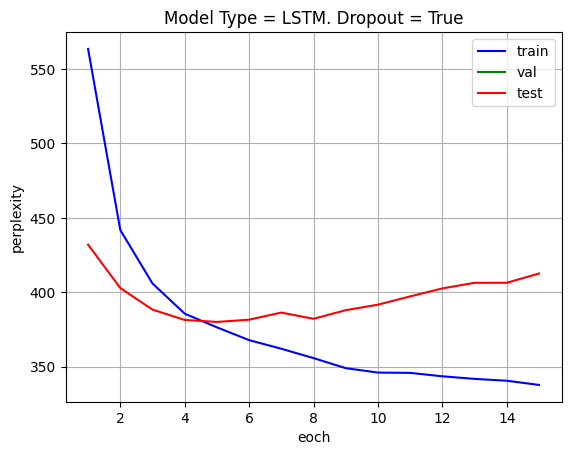

<Figure size 640x480 with 0 Axes>

In [11]:
# hyper params
model_type = "LSTM" #change to GRU 
total_epochs = 15
embedding_dim = 1500
hidden_dim = 200
drop_out = 0.4
learning_rate = 0.05
# hyper params

# First, let's define a custom Dataset to read the vectors of words
class PTBDataset(Dataset):
    def __init__(self, data_, sequence_length_=35):
        # In practice, `data` should be a list of integers representing the words in the PTB data set.
        # self.data = [torch.tensor(item, dtype=torch.long) for item in data]
        self.data = data_
        self.sequence_length = sequence_length_ + 1
  
    def __len__(self):
        return len(self.data) // self.sequence_length
   
    def __getitem__(self, idx):
        x = self.data[idx * self.sequence_length: (idx + 1) * self.sequence_length]
        return x

# Collate function to pad sequences in the same batch to the same length
def collate(batch):
    return pad_sequence(batch, batch_first=True)

# Create a DataLoader
corpus = Corpus('data/ptb')
train_data = corpus.train  
data = train_data
print(data)
dataset = PTBDataset(data)
# dataloader = DataLoader(dataset, batch_size=20, collate_fn=collate, shuffle=True)
dataloader = DataLoader(dataset, batch_size=20, collate_fn=collate, shuffle=True)

# Prepare test data
test_data = corpus.test
test_dataset = PTBDataset(test_data)
test_dataloader = DataLoader(test_dataset, batch_size=1, collate_fn=collate, shuffle=True)

# Now let's define the LSTM language model
class LanguageModel(nn.Module):
    def __init__(self, model_type_, vocab_size, embedding_dim, hidden_dim, nlayers = 2, dropout_ = 0):
        super(LanguageModel, self).__init__()
        self.model_type = model_type_
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.dropout = dropout_
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, num_layers = nlayers, dropout = dropout_)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True, num_layers = nlayers, dropout = dropout_)
        self.linear = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        x = self.embeddings(x)
        if model_type == 'LSTM':
          x, _ = self.lstm(x)
        elif model_type == 'GRU':
          x, _ = self.gru(x)  
        x = self.linear(x)

        return x

# Create the model
vocab_size = len(corpus.dictionary)  

model = LanguageModel(model_type, vocab_size, embedding_dim, hidden_dim, dropout_ = drop_out)

model = model.to(device)

# Define a loss function
loss_function = nn.CrossEntropyLoss()

# Define an optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
results_m = Result_Matrix(f'{model.model_type}. Dropout = {model.dropout != 0}') 

for epoch in range(total_epochs):  
    model.train()
    total_loss = 0.0
    total_samples_count = 0
    for inputs in dataloader:
        inputs = inputs.to(device)        

        targets = inputs[:, 1:].contiguous()
        inputs = inputs[:, :-1].contiguous()

        # Forward pass
        outputs = model(inputs)
        outputs = outputs.view(-1, outputs.size(-1))

        targets = targets.to(device).view(-1)
       
        loss = loss_function(outputs, targets)

        batch_size = inputs.size(0)
        total_loss += loss.item() * batch_size
        total_samples_count += batch_size        
              
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
   
    # Calculate perplexity
    perplexity = np.exp(total_loss / total_samples_count)
    results_m.add_result(perplexity, 'train')  

    print(f"Epoch: {epoch + 1}")
    print(f"Train results - Loss: {loss.item()}, Perplexity: {perplexity.item()}")

    test_model(model)

plot_results(results_m, f'{model.model_type} Dropout = {model.dropout != 0}.jpg')

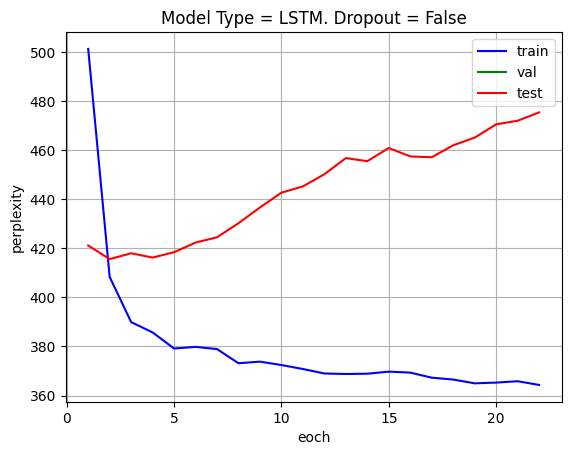

<Figure size 640x480 with 0 Axes>

In [10]:
plot_results(results_m, f'{model.model_type} Dropout = {model.dropout != 0}.jpg')